# Assignment - 3

First, we develop a custom CNN model to classify Dogs, Sheep, and Horses from a custom Animal dataset attached to the assignment.

Second, we classify Cats, Dogs, and Frogs in the CIFAR-10 dataset using a custom CNN model and a pre-trained Googlenet model.


# Importing Required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

# Reading the zip file and extracting the different folders

In [ ]:
import tarfile


target_path = '/content/Animals.tgz'
# Extract the tar files
with tarfile.open(target_path) as tar:
    tar.extractall()

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
import os

# Define the main data directory
data_dir = "Animals"
print(data_dir)

Animals


In [ ]:
for root, _, files in os.walk(data_dir):
  for file in files:
    if file.startswith('._'):
      try:
        os.remove(os.path.join(root, file))
      except Exception as e:
        print(f"Error removing {file}: {str(e)}")

In [ ]:
# Count images and print size
total_images = 0
for root, _, files in os.walk(data_dir):
  for file in files:
    if file.endswith(('.jpg', '.jpeg')):  # Adjust for your image formats
      total_images += 1
      image_path = os.path.join(root, file)

print("Total images downloaded:", total_images)

Total images downloaded: 365


# Displaying few sample images

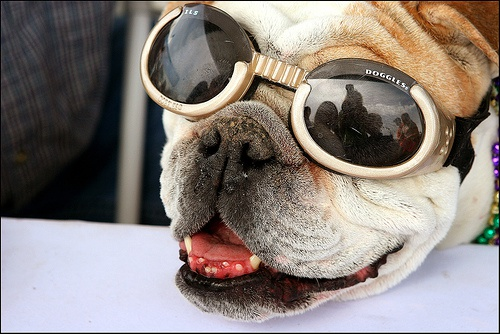

In [ ]:
import pathlib
from PIL import Image

dog_path = pathlib.Path(data_dir) / "Dog"  # Ensure correct path using pathlib
dog_imgs = list(dog_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(dog_imgs[1]))

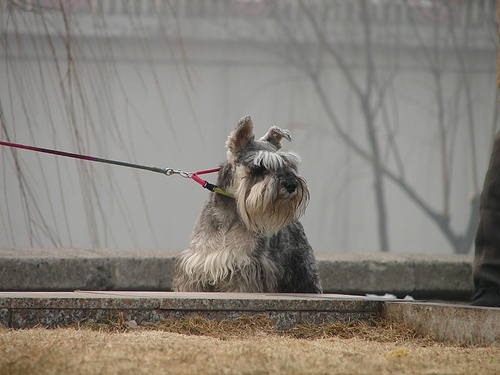

In [ ]:
Image.open(str(dog_imgs[10]))

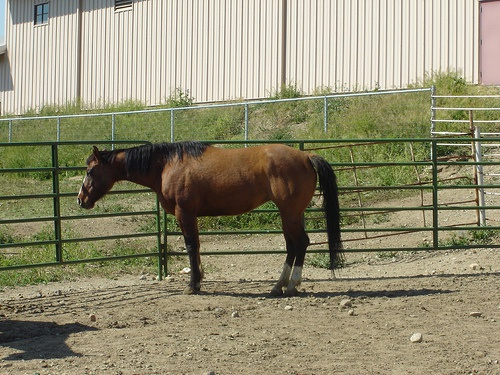

In [ ]:
horse_path = pathlib.Path(data_dir) / "Horse"  # Ensure correct path using pathlib
horse_imgs = list(horse_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(horse_imgs[1]))

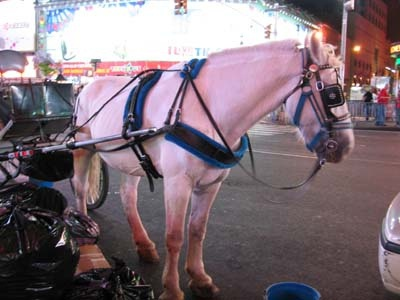

In [ ]:
Image.open(str(horse_imgs[40]))

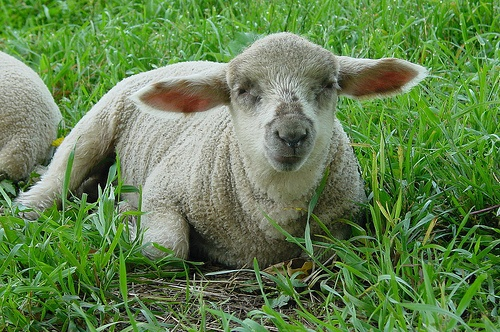

In [ ]:
sheep_path = pathlib.Path(data_dir) / "Sheep"  # Ensure correct path using pathlib
sheep_imgs = list(sheep_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(sheep_imgs[1]))

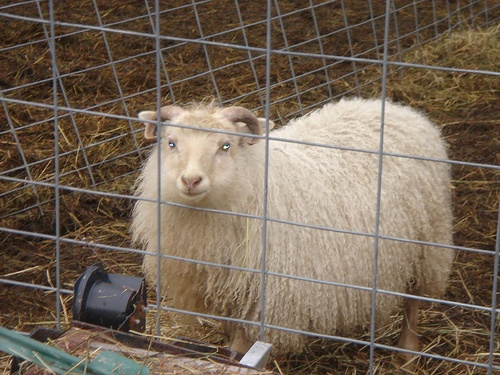

In [ ]:
Image.open(str(sheep_imgs[20]))

# Defining a few transforms on the images

In [ ]:
from torchvision import datasets, transforms

# 1. Load the dataset
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Rescale
])

# Splitting the data into train and validation sets in the 80% and 20%

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(data_dir, transform = data_transform)
train_size = int(0.8 * len(dataset))  # Calculate 80% of dataset size
val_size = len(dataset) - train_size  # Calculate 20% of dataset size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
print(len(train_dataset))

292


In [ ]:
print(len(val_dataset))

73


# Three classes: Dogs, Horse and sheep

In [ ]:
class_names = dataset.classes
print(class_names)

['Dog', 'Horse', 'Sheep']


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Displaying few sample images from the train data loader

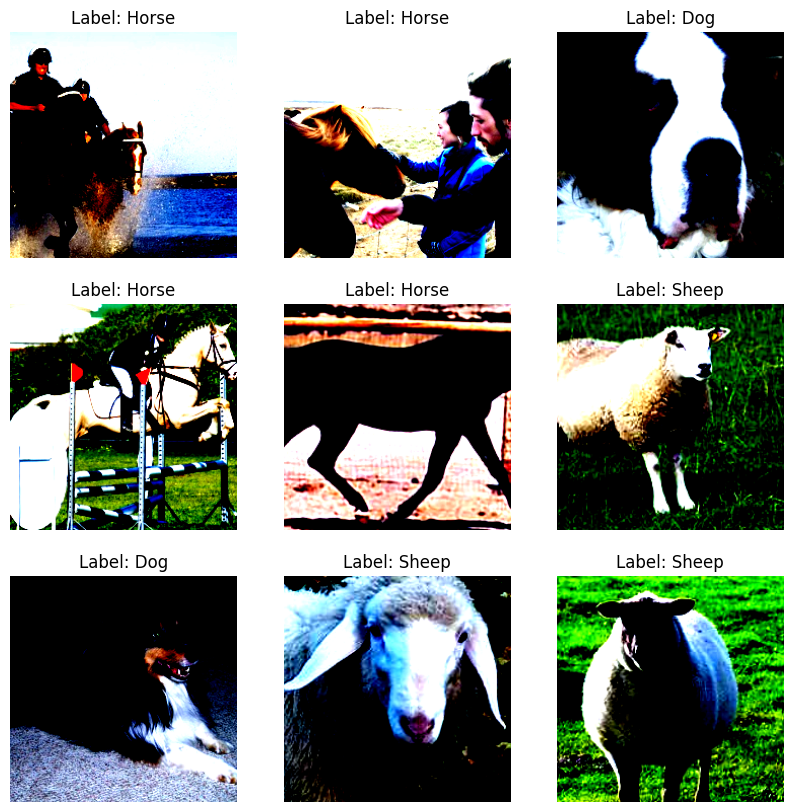

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming train_dl is your PyTorch DataLoader
data_iter = iter(train_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

# Batch size=32 and channels = 3 and image width = 224 and height = 224

In [ ]:
for image_batch, labels_batch in train_dataloader:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
print(len(train_dataloader.dataset))
print(train_dataloader.dataset[0][0].shape)
print(train_dataloader.dataset[1][0].shape)

292
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


# Defining a Custom CNN model

In [ ]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = 3
model = CustomModel(num_classes)

# Print the model architecture
print(model)

CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1605632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input dimensions
img_height, img_width = 224, 224
# Define the number of classes
num_classes = 3

# Instantiate the model
model = CNNModel(num_classes, img_height, img_width)

# Training the Custom CNN model

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 5  # Choose the number of epochs
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 1.2228, Accuracy: 0.3425
Epoch 2/5, Loss: 1.0490, Accuracy: 0.4384
Epoch 3/5, Loss: 0.9390, Accuracy: 0.5822
Epoch 4/5, Loss: 0.7514, Accuracy: 0.6610
Epoch 5/5, Loss: 0.6271, Accuracy: 0.7466


Using Data augmentation and training the model

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, loss_list, acc_list, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(data_augmented_inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)

# Train the model
num_epochs = 5  # Choose the number of epochs
loss_list = list()
acc_list = list()
train_model(model, train_dataloader, criterion, optimizer, loss_list, acc_list, num_epochs)

Epoch 1/5, Loss: 0.4234, Accuracy: 0.8459
Epoch 2/5, Loss: 0.2410, Accuracy: 0.9247
Epoch 3/5, Loss: 0.1187, Accuracy: 0.9760
Epoch 4/5, Loss: 0.1260, Accuracy: 0.9623
Epoch 5/5, Loss: 0.1560, Accuracy: 0.9349


# Plotting train accuracy and loss

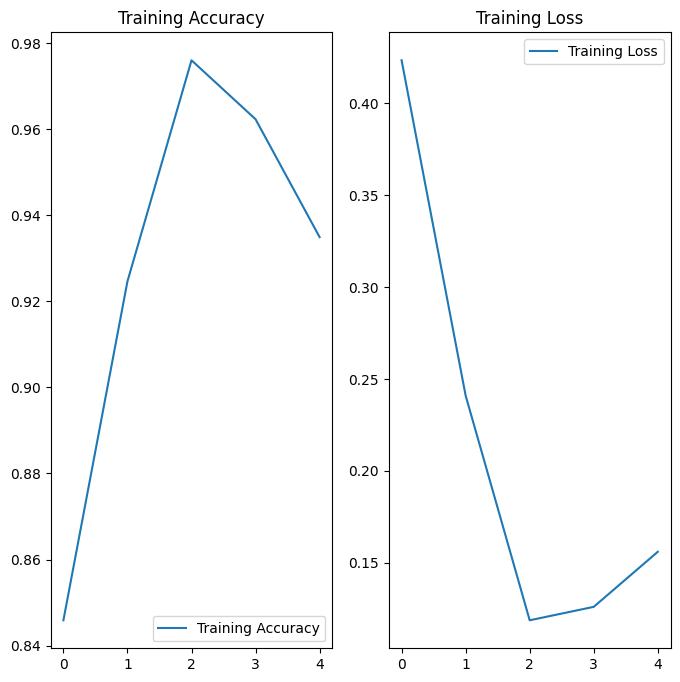

In [ ]:
epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_list, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_list, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

# Displaying a few transformed images

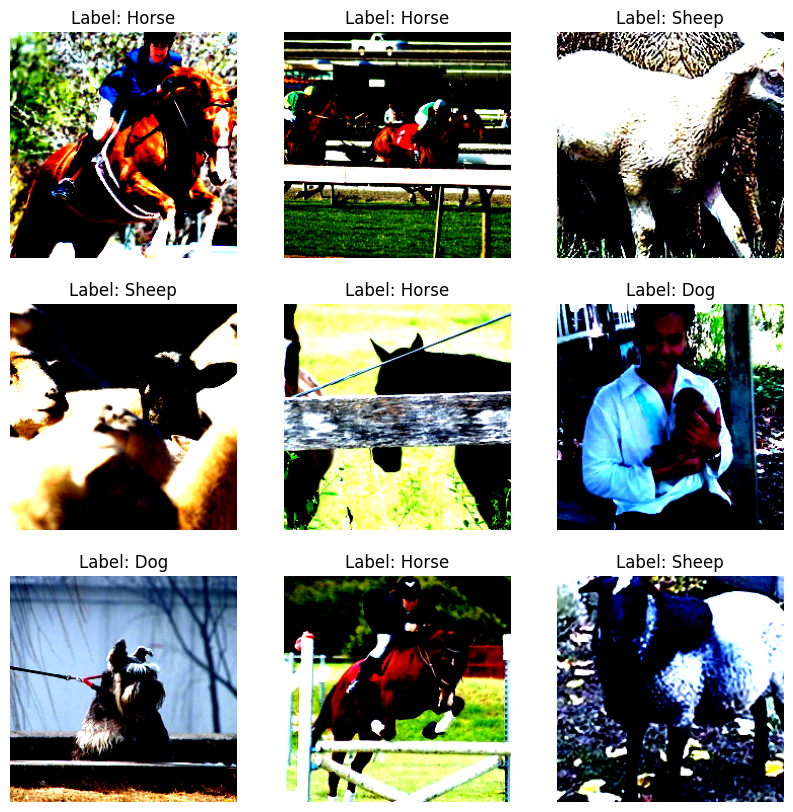

In [ ]:
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

# Predicting classes for a few sample images

In [ ]:
from torch import argmax
import pandas as pd

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)

predicted_class = list()
actual_class = list()
# Convert tensor to numpy array
for prob in probabilities:
  predicted_class.append(class_names[argmax(prob)])

#print(confidence)
for i in range(len(labels)):
  actual_class.append(class_names[labels[i]])


actual_vs_pred = pd.DataFrame(list(zip( actual_class, predicted_class)),
               columns =['actual_class', 'predicted_class'])

In [ ]:
from tabulate import tabulate

print(tabulate(actual_vs_pred, headers = 'keys', tablefmt = 'psql'))

+----+----------------+-------------------+
|    | actual_class   | predicted_class   |
|----+----------------+-------------------|
|  0 | Horse          | Sheep             |
|  1 | Horse          | Horse             |
|  2 | Sheep          | Sheep             |
|  3 | Sheep          | Sheep             |
|  4 | Horse          | Sheep             |
|  5 | Dog            | Dog               |
|  6 | Dog            | Sheep             |
|  7 | Horse          | Horse             |
|  8 | Sheep          | Sheep             |
|  9 | Dog            | Sheep             |
| 10 | Sheep          | Sheep             |
| 11 | Dog            | Horse             |
| 12 | Dog            | Horse             |
| 13 | Horse          | Sheep             |
| 14 | Dog            | Dog               |
| 15 | Dog            | Horse             |
| 16 | Horse          | Horse             |
| 17 | Horse          | Horse             |
| 18 | Sheep          | Sheep             |
| 19 | Horse          | Horse   

# Testing the custom CNN model on the 20% test data

In [ ]:
def test_model(model, test_dl):

  model.eval()  # Set the model to train mode
  test_loss = 0.0
  test_acc = 0.0

  for images, labels in test_dl:
    outputs = model(images)

    # Compute training accuracy
    acc = accuracy(outputs, labels)
    test_acc += acc.item() * images.size(0)

  full_acc = test_acc / len(test_dl.dataset)
  print(f'Test Accuracy: {full_acc:.4f}')

# Test the model
test_model(model, val_dataloader)

Test Accuracy: 0.5068


# Using CIFAR-10 data set for image classification using of Cats, Dogs and Frogs

# Import all the required libraries

In [1]:
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models

# Defining basic transformations to

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
batch_size = 32

# Downloading the CIFAR 10 train and test dataset

In [5]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 30380685.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


# The image size is 3 X 32 X 32 i.e. 3 channels, 32 width and 32 height

In [7]:
train_set[0][0].size()

torch.Size([3, 32, 32])

# Classes in the dataset

In [8]:
classes = ('Aeroplane', 'motorcar', 'bird', 'cat', 'deer', 'puppy', 'frog', 'stallion', 'cruise', 'truck')
print("defined classes")

defined classes


# Desired classes are cat, dog and frog, retaining data points with desired classes in train and test sets

In [9]:
desired_classes = ['cat', 'dog', 'frog']

# Get the indices corresponding to the desired classes
indices = []
for i in range(len(train_set)):
    if train_set.targets[i] in [train_set.class_to_idx[c] for c in desired_classes]:
        indices.append(i)

# Create a subset of the CIFAR-10 dataset containing only the desired classes
subset_dataset = Subset(train_set, indices)

In [10]:
# Create a data loader for the subset dataset
batch_size = 32
train_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [11]:
# Get the indices corresponding to the desired classes
indices = []
for i in range(len(test_set)):
    if test_set.targets[i] in [test_set.class_to_idx[c] for c in desired_classes]:
        indices.append(i)

# Create a subset of the CIFAR-10 dataset containing only the desired classes
subset_dataset = Subset(test_set, indices)

# Create a data loader for the subset dataset
batch_size = 32
test_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Displaying a few sample images

fig1.jpg


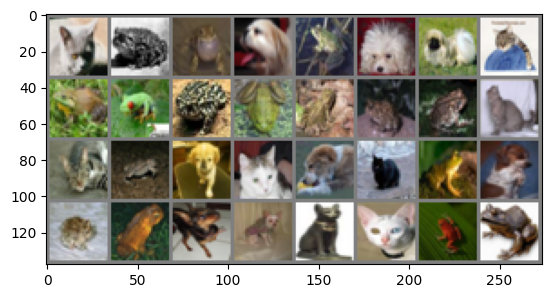

  cat  frog  frog puppy  frog puppy puppy   cat  frog  frog  frog  frog  frog  frog  frog   cat   cat  frog puppy   cat   cat   cat  frog puppy  frog  frog puppy puppy   cat   cat  frog  frog
image created and saved 


In [12]:
global image_number
image_number = 0
def show_image(img):
    global image_number
    image_number = image_number + 1
    img = img / 2 + 0.5     # de-normalizing input image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig("fig{}.jpg".format(image_number))
    print("fig{}.jpg".format(image_number))
    plt.show()
data_iter = iter(train_loader)
images, labels = next(data_iter)
show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j].item()] for j in range(batch_size)))
print("image created and saved ")

# Defining a CNN model

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(3, 6, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
print("created Net() ")

created Net() 


# Training the model

In [14]:
import torch.optim as optim
import torch.nn.functional as F

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

num_epochs = 10
net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    train_acc = 0.0
    train_loss = 0.0

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels[labels==3] = 0
        labels[labels==5] = 1
        labels[labels==6] = 2

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        acc = accuracy(outputs, labels)
        train_acc += acc.item() * inputs.size(0)

        # Track training loss
        train_loss += loss.item() * inputs.size(0)

    # Print training statistics
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_acc / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


print('Finished Training')

Epoch 1/10, Loss: 1.0979, Accuracy: 0.3492
Epoch 2/10, Loss: 1.0922, Accuracy: 0.4635
Epoch 3/10, Loss: 1.0386, Accuracy: 0.4914
Epoch 4/10, Loss: 0.9221, Accuracy: 0.5382
Epoch 5/10, Loss: 0.8368, Accuracy: 0.5903
Epoch 6/10, Loss: 0.7879, Accuracy: 0.6161
Epoch 7/10, Loss: 0.7591, Accuracy: 0.6345
Epoch 8/10, Loss: 0.7443, Accuracy: 0.6449
Epoch 9/10, Loss: 0.7241, Accuracy: 0.6556
Epoch 10/10, Loss: 0.7234, Accuracy: 0.6537
Finished Training


# Saving the model and predicting classes for few sample outputs

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print("saved model to path :",PATH)
net = Net()
net.load_state_dict(torch.load(PATH))
print("loding back saved model")
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % desired_classes[predicted[j]] for j in range(4)))
correct = 0
total = 0

saved model to path : ./cifar_net.pth
loding back saved model
Predicted:    cat  frog   cat  frog


# Test data accuracy using Custom CNN model

In [ ]:
# calculate outputs by running images through the network
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels[labels==3] = 0
        labels[labels==5] = 1
        labels[labels==6] = 2
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what you can choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on test images using CNN model: %d %%' % ( 100 * correct / total))
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

Accuracy of the network on test images using CNN model: 68 %


# Transfer learning using pre-trained model - GoogleNet

In [ ]:
model_transfer =  models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 111MB/s]


# Adding a new linear layer for the pre-trained model

In [ ]:
for param in model_transfer.parameters():
    param.requires_grad = False

# replace the last fully connected layer with a Linnear layer
in_features = model_transfer.fc.in_features
#TODO
# Fill out the out feature that we need
model_transfer.fc = nn.Linear(in_features, 3)

In [ ]:
#let's see the model
from torchsummary import summary
summary(model_transfer, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
       BasicConv2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 192, 8, 8]         110,592
       BatchNorm2d-9            [-1, 192, 8, 8]             384
      BasicConv2d-10            [-1, 192, 8, 8]               0
        MaxPool2d-11            [-1, 192, 4, 4]               0
           Conv2d-12             [-1, 64, 4, 4]          12,288
      BatchNorm2d-13             [-1, 64, 4, 4]             128
      BasicConv2d-14             [-1, 6

# Defining Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
model_transfer_grad_paramaters = filter(lambda p: p.requires_grad, model_transfer.parameters())
optimizer = torch.optim.Adam(model_transfer_grad_paramaters, lr=0.001)

# Training the googlenet model and getting train accuracy

In [ ]:
# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

num_epochs = 10
model_transfer.train()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    train_acc = 0.0
    train_loss = 0.0

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels[labels==3] = 0
        labels[labels==5] = 1
        labels[labels==6] = 2

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_transfer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        acc = accuracy(outputs, labels)
        train_acc += acc.item() * inputs.size(0)

        # Track training loss
        train_loss += loss.item() * inputs.size(0)

    # Print training statistics
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_acc / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


print('Finished Training')

Epoch 1/10, Loss: 0.9811, Accuracy: 0.5145
Epoch 2/10, Loss: 0.9344, Accuracy: 0.5482
Epoch 3/10, Loss: 0.9460, Accuracy: 0.5417
Epoch 4/10, Loss: 0.9394, Accuracy: 0.5446
Epoch 5/10, Loss: 0.9432, Accuracy: 0.5465
Epoch 6/10, Loss: 0.9328, Accuracy: 0.5525
Epoch 7/10, Loss: 0.9285, Accuracy: 0.5497
Epoch 8/10, Loss: 0.9391, Accuracy: 0.5481
Epoch 9/10, Loss: 0.9366, Accuracy: 0.5484
Epoch 10/10, Loss: 0.9362, Accuracy: 0.5509
Finished Training


# Calculating test accuracy

In [ ]:
correct = 0
total = 0
# calculate outputs by running images through the network
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels[labels==3] = 0
        labels[labels==5] = 1
        labels[labels==6] = 2
        # calculate outputs by running images through the network
        outputs = model_transfer(images)
        # the class with the highest energy is what you can choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on test images using Googlenet Pretrained model: %d %%' % ( 100 * correct / total))
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

Accuracy of the network on test images using Googlenet Pretrained model: 53 %


# Testing pre-trained googlenet model with a sample image

In [ ]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)

(-0.5, 1545.5, 1212.5, -0.5)

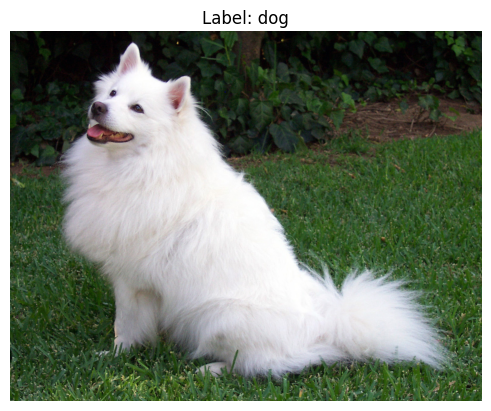

In [ ]:
image = input_image  # Convert tensor to numpy array
plt.imshow(image)
plt.title(f"Label: dog")
plt.axis("off")

In [ ]:
# Load and preprocess the unseen image
preprocess = transforms.Compose(
        [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [ ]:
outputs = model_transfer(input_batch)

In [ ]:
_, preds = torch.max(outputs, dim=1)
print('The sample image is a :',desired_classes[preds])

The sample image is a : dog


# Conclusion:





*   The training accuracy was 65.37% and the test accuracy was 63% using a custom CNN model for the CIFAR-10 dataset
*   The training accuracy was 55% and the test accuracy was 53% using a custom CNN model for the CIFAR-10 dataset
*   Practically pre-trained models are supposed to perform better than traditional custom CNN
*   Since the dataset has low resolution and sometimes the pre-trained models perform poorly than traditional custom CNN models on few datasets, thus for the CIFAR-10 dataset the pre-trained model performed poorly with 54% accuracy than the Custom CNN model with 63%.

